In [97]:
import os
import matplotlib as mpl
import matplotlib.pylab as plt
import itertools
import csv , codecs
import glob
from PIL import Image
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn import decomposition
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss



In [98]:
data_dir = "./EEG_data/"

## CSV 파일 생성 함수

In [99]:
def EEG_data_csv(data_dir):
    
    # Kinds of Power 입력
    file_list = os.listdir(data_dir)
    file_list.sort()
    print("Kinds of Power" ,file_list)
       
    global kinds_of_power
    kinds_of_power =str(input( "Kinds of Power : "))
    
    excel_dir = "./EEG_data" + '/' + kinds_of_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    # EEG_csv_data 디렉토리 생성
    csv_dir = "./EEG_csv_data"
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    
    Abs_dir ="./EEG_csv_data/Abs"
    Relative_dir = "./EEG_csv_data/Relative"
    
    if not os.path.isdir(Abs_dir):
        os.mkdir(Abs_dir)
    if not os.path.isdir(Relative_dir):
        os.mkdir(Relative_dir)
    
    book = Workbook()
    sheet = book.active
    
    # x축,y축 생성
    for i in range (1,21) :
        if i < 10 :
            sheet['A'+str(i+1)] = 'S0'+str(i)
        if i == 10 :
            sheet['A'+str(i+1)] = 'S'+str(10)
        if i > 10 :
            sheet['A'+str(i+1)] = 'S'+str(i)
            
    for j in range (0,12):
        for i in range(1,33):
            sheet.cell(row=1, column=160*j+i+1).value = 'ACh' + str(i)
            sheet.cell(row=1, column=160*j+i+33).value = 'BCh' + str(i)
            sheet.cell(row=1, column=160*j+i+65).value = 'DCh' + str(i)
            sheet.cell(row=1, column=160*j+i+97).value = 'GCh' + str(i)
            sheet.cell(row=1, column=160*j+i+129).value = 'TCh' + str(i)

    # 파일을 순차적으로 열어서 셀 영역을 복사
    # j: 엑셀 파일의 수, k: 각 엑셀 파일 당 시트의 수, n: task의 수, l: subject의 수, m: ch1-ch32

    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=l,column=160*k+m+32*j).value = source.cell(row=l,column=m).value

    # EEG_csv_data 디렉토리에 csv 파일로 저장
    if kinds_of_power == "Abs":
        with open(Abs_dir + str('/') +'Abs_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])
    elif kinds_of_power == "Relative":
        with open(Relative_dir + str('/') +'Relative_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])

## CSV 파일에서 Pandas dataframe으로 가져오는 함수

In [100]:
def data_setting(task, eye , respiratory):
    # 성재가 만든 파일 불러오는 경로 입력 및 데이터 프레임으로 불러올것 
    ##  Abs, Relative 설정은 여기서 변경하기기
    csv_name = "./EEG_csv_data/Abs/Abs_Merged.csv"
    data = pd.read_csv(csv_name) 
    data_column = data.columns
    
    
    # 1 back
    if task == 0 : 
        if respiratory == 0 :
            data = data[data_column[1:161]]
            # 1-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            
            
            
        elif respiratory == 1 :
            data = data[data_column[161:321]]
            # 1-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[321:481]]
            # 1-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    # 2 back
    elif task == 1 : 
        if respiratory == 0 :
            data = data[data_column[481:641]]
            # 2-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 1 :
            data= data[data_column[641:801]]
            # 2-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[801:961]]
            # 2-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    #resting
    elif task == 2 :
        ## eye ==0 close eye
        if eye == 0 :
            if respiratory == 0 :
                data = data[data_column[961:1121]]
                # resting open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1121:1281]]
                # resting open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1281:1441]]
                # resting open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
        ## eye ==1 open eye
        if eye == 1 : 
            if respiratory == 0 :
                data = data[data_column[1441:1601]]
                # resting close eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1601:1761]]
                # resting close eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1761:1921]]
                # resting close eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))

    
    
    
    
    return data
                
                
# column indexing task condition

### task list

In [101]:
wb = openpyxl.load_workbook(data_dir+ str('/') +'Relative'+str('/')+'R_Alpha.xlsx')
wb_sheet = wb.sheetnames
wb_sheet

['B1_M',
 'B1_N',
 'B1_O2',
 'B2_M',
 'B2_N',
 'B2_O2',
 'Rest_EC_M',
 'Rest_EC_N',
 'Rest_EC_O2',
 'Rest_EO_M',
 'Rest_EO_N',
 'Rest_EO_O2']

### Kinds of Power 입력

In [102]:
EEG_data_csv(data_dir)

Kinds of Power ['Abs', 'Relative']


Kinds of Power :  Relative



### task 0 1 2 : 1-back  2-back  rest

### eye 0  1    : close eye     open eye

### respiratory 0 1 2 : mouse nose o2 



---

### SVM dataset 만드는 함수

In [103]:
def dataset_csv():
    
    excel_dir = "./EEG_data" + '/' + "Abs"
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    subject = int(input("subject :"))
    

    book = Workbook()
    sheet = book.active
    sheet.cell(row=1, column=161).value = 'target'
 
    # x축 생성   
    for i in range(1,33):
        sheet.cell(row=1, column=i).value = 'ACh' + str(i)
        sheet.cell(row=1, column=i+32).value = 'BCh' + str(i)
        sheet.cell(row=1, column=i+64).value = 'DCh' + str(i)
        sheet.cell(row=1, column=i+96).value = 'GCh' + str(i)
        sheet.cell(row=1, column=i+128).value = 'TCh' + str(i)
        
    # 파일을 순차적으로 열어서 셀 영역을 복사
    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=20*k+l,column=32*j+m-1).value = source.cell(row=l,column=m).value
        

    with open('./dataset_eeg.csv', 'w', newline="") as f:
        c = csv.writer(f)
        for r in sheet.rows:
            c.writerow([cell.value for cell in r])
            
    df = pd.read_csv('./dataset_eeg.csv')
    df[df =='                      NaN'] =np.nan
    df = df.fillna(0.0).astype('float64')
    pd.options.mode.chained_assignment = None

    df["target"][0*subject:1*subject] = "010"
    df["target"][1*subject:2*subject] = "011"
    df["target"][2*subject:3*subject] = "012"

    df["target"][3*subject:4*subject] = "110"
    df["target"][4*subject:5*subject] = "111"
    df["target"][5*subject:6*subject] = "112"

    df["target"][6*subject:7*subject] = "200"
    df["target"][7*subject:8*subject] = "201"
    df["target"][8*subject:9*subject] = "202"

    df["target"][9*subject:10*subject] = "210"
    df["target"][10*subject:11*subject] = "211"
    df["target"][11*subject:12*subject] = "212"
    df.astype('float64')
    df.to_csv('./dataset_eeg.csv')
    
    return df
            


In [104]:
eeg_data = dataset_csv()
eeg_data

subject : 20


C:\Users\hyg44\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,ACh1,ACh2,ACh3,ACh4,ACh5,ACh6,ACh7,ACh8,ACh9,ACh10,...,TCh24,TCh25,TCh26,TCh27,TCh28,TCh29,TCh30,TCh31,TCh32,target
0,34.791231,43.380524,35.326932,33.483708,56.872380,80.370204,214.133509,336.869775,381.856303,273.700635,...,13.427554,8.834771,14.327464,14.443761,7.069934,2.461342,1.918468,3.426660,2.290185,010
1,21.332838,24.823823,7.732816,9.217822,9.089609,8.036041,15.609924,23.939677,45.026376,32.271230,...,13.955683,23.515145,33.013509,51.655861,26.336138,4.967240,4.443262,4.745022,4.208323,010
2,36.186846,30.996535,10.170486,9.205632,7.786313,11.105612,15.048448,23.943661,62.093379,51.073027,...,5.010105,15.810370,20.048230,32.001265,10.859633,1.375167,1.457062,1.650200,1.416968,010
3,165.706432,160.501820,53.815336,62.235116,55.541734,71.253082,91.474654,135.868921,134.070627,136.141713,...,16.361836,68.210183,54.308069,148.442087,63.703027,7.818248,6.864512,4.247089,4.067750,010
4,22.634142,32.687601,12.911995,12.740504,10.412052,13.157750,18.063993,45.134604,28.956921,28.032936,...,6.803263,10.276619,11.929224,19.722379,8.552856,2.337217,1.963548,1.735394,1.721120,010
5,9.904728,12.106190,5.481018,5.883165,6.943520,4.971094,11.073126,21.883341,28.940616,17.855794,...,5.201979,8.331477,9.298878,14.191144,6.611382,2.270006,1.609459,2.243871,1.464934,010
6,18.326832,18.923015,11.541991,11.720848,21.818624,16.801940,44.238363,45.513382,86.959537,96.298758,...,10.462003,6.948912,16.636356,19.600377,11.220615,4.065819,3.602533,4.167830,3.110982,010
7,24.845787,25.098427,9.968054,10.518397,11.365719,14.987010,34.950889,85.022078,65.631135,67.088813,...,13.238787,30.234171,23.676020,44.214361,45.812588,7.498409,4.584952,4.489311,4.936536,010
8,40.920388,38.523930,20.494293,16.728225,22.788190,17.159516,46.666191,66.393587,77.053292,70.261983,...,6.364726,11.050834,11.586133,21.515216,8.912505,2.377013,2.058713,2.536856,1.795944,010
9,38.508282,42.220113,8.909832,10.129484,11.125612,11.333431,59.035223,71.950390,127.573202,117.084965,...,4.425120,8.617088,9.871563,17.264892,6.362957,1.312544,1.445537,1.684411,1.398925,010


In [105]:
from sklearn.ensemble import RandomForestClassifier
X = eeg_data.iloc[:,0:-1]
X1=np.array(X)
Y = eeg_data['target']
Y1= np.array(Y)


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
for name, score in zip(X.columns.tolist(), rnd_clf.feature_importances_):
    print(name, score)

ACh1 0.006500489410300433
ACh2 0.006514176034245505
ACh3 0.005086763363483227
ACh4 0.005443194353687278
ACh5 0.0062936649381654525
ACh6 0.005987621986374156
ACh7 0.006426404065709535
ACh8 0.008423730453823886
ACh9 0.009492279117543878
ACh10 0.009611399146034288
ACh11 0.005579794219352037
ACh12 0.00486206705296602
ACh13 0.0074805018328755
ACh14 0.007124867515877313
ACh15 0.007883306881065932
ACh16 0.006652224536933198
ACh17 0.006027927706686985
ACh18 0.0
ACh19 0.006637728559293544
ACh20 0.008618161065838903
ACh21 0.00623581614582102
ACh22 0.007771331789701724
ACh23 0.007063155647755652
ACh24 0.007182013446389825
ACh25 0.005097222487916274
ACh26 0.006359518187539967
ACh27 0.007042912694437257
ACh28 0.0052772899248591226
ACh29 0.005905799673322853
ACh30 0.006025081546358427
ACh31 0.007035089336986447
ACh32 0.006111908247821821
BCh1 0.007892921607084807
BCh2 0.011751832406160042
BCh3 0.005865855414312579
BCh4 0.005130708986098525
BCh5 0.007030651174638833
BCh6 0.006892592713185618
BCh7 0.0

---

무작위로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모으면 많은 경우 전문가의 답보다 이렇게 모은 답이 낫습니다. 

이를 **대중의 지혜(wisdom of crowd)** 라고 합니다.



이와 비슷하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있습니다. 

일련의 예측기를 **앙상블(ensemble)** 이라고 부릅니다. 


Decision tree의 ensemble을 **Random Forest**라고 합니다. 

---



###    1. 160개의 feature 중에서 Randomforest classification을 통해 Feature importance로 상위 몇 개의 feature를 선택합니다.


###    2. 선택한 상위 feature 들을 Linear Discriminant Analysis(LDA)를 적용하여 차원 축소를 진행합니다.


###    3. 줄어든 Dimension 상에서 RandomForest와 같은 Enseble Classification을 진행합니다. 


* Linear Discriminant Analysis (LDA)은 훈련과정에서 클래스 사이를 가장 잘 구분하는 축을 학습합니다. 이 축은 데이터가 투영되는 hyperplane을 정의하는데 사용할 수 있습니다.
이 알고리즘의 장점은 projection을 통해 가능한 한 클래스를 멀리 떨어지게 유지하므로 SVM과 같은 다른 classification 알고리즘을 적용하기 전에 차원을 축소시키는데 좋습니다

# Random forest classification을 사용하여 feature importance를 알아냅니다.


In [106]:
from sklearn.ensemble import RandomForestClassifier

# channel은 feature 이름과 feature importance를 같이 담고 있는 list
channel = []
# choice된 top feature list
choice_feature =[]


#######################################################################
#   Random forest classification을 사용하여 feature importance를 얻어냄#      
#######################################################################
X = eeg_data.iloc[:,0:-1]
Y = eeg_data['target']
X1 = np.array(eeg_data.iloc[:,0:-1])
Y1 = np.array(eeg_data['target'])
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [107]:
# feature importance를 얻어내기 위해 사용한 Randomforest의 정확도
rnd_clf.score(X_test,y_test)

0.016666666666666666

### 얻어낸 feature importance를 이용하여 feature importances가 높은 Channel을 선택합니다.

In [108]:


print("1~155, (feature importance, 'ACh18,BCh18,DCh18,GCh18,TCh18'=0 )")
aa= int(input("top feature of number : " ))
feature_list= list(zip(X.columns.tolist(),rnd_clf.feature_importances_))
feature_dict= dict(zip(X.columns.tolist(),rnd_clf.feature_importances_))
sorted_feature = sorted(feature_dict.values(), reverse=True)
top_feature = sorted_feature[0:aa]


for i in range(len(feature_list)):
    for j in range(len(top_feature)):
        if feature_list[i][1] == top_feature[j]:
            channel.append(feature_list[i])
        else:
            continue
            
for i in range(len(channel)):
    choice_feature.append(channel[i][0])
    
#print(choice_feature)
choice_feature_df = eeg_data[choice_feature]
choice_feature_df.shape

1~155, (feature importance, 'ACh18,BCh18,DCh18,GCh18,TCh18'=0 )


top feature of number :  2


(240, 2)


# Channel(feature)을 feature importance 내림차순으로 정렬합니다.

In [109]:

sorted_channel=[]
ranked_feature = sorted(top_feature,reverse=True) 
for i in range(len(channel)):
    for j in range(len(channel)):
        if channel[j][1] == ranked_feature[i]:
            sorted_channel.append(channel[j])
        else:
            continue
sorted_channel

[('GCh2', 0.01596222864388405), ('GCh26', 0.014158031322610709)]

In [110]:
len(channel)

2

In [111]:
X2 = np.array(choice_feature_df.iloc[:])

In [112]:
Y2= np.array(Y)

### LDA 적용후 k-fold validation으로 RandomForest진행

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X2,Y2)
all_scores = []

rnd_clf = RandomForestClassifier(n_estimators=500)
lda = LinearDiscriminantAnalysis(n_components=None)

lda = LinearDiscriminantAnalysis(n_components=11)
lda.fit(X2,Y2)

X_reduced_lda = lda.transform(X2)


for train_index, test_index in skf.split(X_reduced_lda,Y2):
    rnd_clf.fit(X_reduced_lda[train_index], Y2[train_index])
    val_mae = rnd_clf.score(X_reduced_lda[test_index],Y2[test_index])
    all_scores.append(val_mae)
    
print(all_scores)

[0.125, 0.08333333333333333, 0.08333333333333333, 0.16666666666666666, 0.125, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.125]


In [114]:
print(np.mean(all_scores)*100,"%")

10.416666666666666 %


# feature 수 변화에 따른 정확도 변화 그래프 

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


def feature_select(feature_number ):
    # channel은 feature 이름과 feature importance를 같이 담고 있는 list
    channel = []
    # choice된 top feature list
    choice_feature =[]


    #######################################################################
    #   Random forest classification을 사용하여 feature importance를 얻어냄#      
    #######################################################################
    X = eeg_data.iloc[:,0:-1]
    Y = eeg_data['target']
    X1 = np.array(eeg_data.iloc[:,0:-1])
    Y1 = np.array(eeg_data['target'])
    X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    rnd_clf.fit(X_train, y_train)

    feature_list= list(zip(X.columns.tolist(),rnd_clf.feature_importances_))
    feature_dict= dict(zip(X.columns.tolist(),rnd_clf.feature_importances_))
    sorted_feature = sorted(feature_dict.values(), reverse=True)
    top_feature = sorted_feature[0:int(feature_number)]


    for i in range(len(feature_list)):
        for j in range(len(top_feature)):
            if feature_list[i][1] == top_feature[j]:
                channel.append(feature_list[i])
            else:
                continue
            
    for i in range(len(channel)):
        choice_feature.append(channel[i][0])
    
    #print(choice_feature)
    choice_feature_df = eeg_data[choice_feature]
    #print(choice_feature_df.shape)
    
    sorted_channel=[]
    ranked_feature = sorted(top_feature,reverse=True) 
    for i in range(len(channel)):
        for j in range(len(channel)):
            if channel[j][1] == ranked_feature[i]:
                sorted_channel.append(channel[j])
            else:
                continue
    #print(sorted_channel)
    X2 = np.array(choice_feature_df.iloc[:])
    Y2= np.array(Y)
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    skf.get_n_splits(X2,Y2)
    all_scores = []

    rnd_clf = RandomForestClassifier(n_estimators=500)
    lda = LinearDiscriminantAnalysis(n_components=None)

    lda = LinearDiscriminantAnalysis(n_components=11)
    lda.fit(X2,Y2)

    X_reduced_lda = lda.transform(X2)


    for train_index, test_index in skf.split(X_reduced_lda,Y2):
        rnd_clf.fit(X_reduced_lda[train_index], Y2[train_index])
        val_mae = rnd_clf.score(X_reduced_lda[test_index],Y2[test_index])
        all_scores.append(val_mae)
    
    
    return np.mean(all_scores)*100

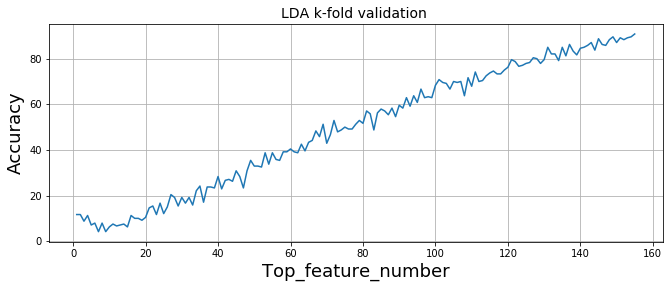

In [116]:
result = []
num = []
for i in range(1,156):
    result.append(feature_select(i))
    num.append(i)
    
plt.figure(figsize=(11,4))
plt.title("LDA k-fold validation ", fontsize=14)
plt.xlabel("Top_feature_number", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.plot(num,result)
plt.grid(True)
plt.show()

In [117]:
result

[11.666666666666666,
 11.666666666666666,
 8.75,
 11.25,
 7.083333333333333,
 7.916666666666665,
 4.166666666666666,
 7.916666666666665,
 4.166666666666666,
 6.25,
 7.5,
 6.666666666666667,
 7.083333333333333,
 7.5,
 6.249999999999998,
 11.25,
 10.0,
 10.0,
 9.166666666666668,
 10.416666666666666,
 14.583333333333334,
 15.416666666666664,
 11.666666666666666,
 16.666666666666668,
 12.083333333333332,
 15.0,
 20.416666666666668,
 19.166666666666664,
 15.416666666666668,
 19.166666666666664,
 16.666666666666664,
 19.166666666666668,
 15.833333333333336,
 22.08333333333333,
 24.16666666666667,
 17.083333333333332,
 23.750000000000004,
 23.75,
 23.333333333333332,
 28.333333333333332,
 22.916666666666664,
 26.66666666666667,
 27.083333333333336,
 26.25,
 30.83333333333333,
 28.333333333333332,
 23.333333333333332,
 30.83333333333333,
 35.416666666666664,
 32.91666666666667,
 32.916666666666664,
 32.5,
 38.74999999999999,
 33.75,
 38.75,
 35.833333333333336,
 35.416666666666664,
 39.1666666

In [119]:
len(result)

155

In [120]:
max(result)

90.83333333333331